## Quantum Portfolio Optimization

In [4]:
# Install Libraries
#!pip install qiskit qiskit-finance qiskit-optimization yfinance pandas numpy matplotlib

In [5]:
# Surpress any warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

## Downloading data

In [6]:
import yfinance as yf
import pandas as pd
import datetime

print("Data Acquisition")
# Pick 10 stocks 
tickers = [
    'AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 
    'JPM', 'JNJ', 'V', 'PG', 'NVDA'
]
# Define training time period
train_start_date = '2024-10-01'
train_end_date = '2024-10-29' # 20 trading days

# Define testing time period
test_start_date = '2024-10-30'
test_end_date = '2024-11-12' # 10 trading days

print(f"Initializing project with {len(tickers)} tickers.")
print(f"Training Period: {train_start_date} to {train_end_date}")
print(f"Testing Period: {test_start_date} to {test_end_date}")

# Download training data
print("Downloading training data...")
try:
    # Download data - yfinance returns MultiIndex columns for multiple tickers
    raw_data = yf.download(tickers, start=train_start_date, end=train_end_date)
    
    # Extract 'Adj Close' or 'Close' prices - handle different yfinance versions
    if isinstance(raw_data.columns, pd.MultiIndex):
        # Try to get Adj Close first, fall back to Close
        if 'Adj Close' in raw_data.columns.get_level_values(0):
            stock_data = raw_data['Adj Close']
            print("Using 'Adj Close' prices.")
        elif 'Close' in raw_data.columns.get_level_values(0):
            stock_data = raw_data['Close']
            print("Note: Using 'Close' prices (Adj Close not available).")
        else:
            raise ValueError("Cannot find price data in downloaded data")
    else:
        # Single level columns - likely single ticker
        if 'Adj Close' in raw_data.columns:
            stock_data = raw_data['Adj Close']
            print("Using 'Adj Close' prices.")
        elif 'Close' in raw_data.columns:
            stock_data = raw_data['Close']
            print("Note: Using 'Close' prices (Adj Close not available).")
        else:
            raise ValueError("Cannot find price data in downloaded data")
    
    print("Training data downloaded successfully.")

    # Validate and clean data
    if stock_data.isnull().values.any():
        print("Missing data found. Filling missing values with forward fill method.")
        stock_data.fillna(method='ffill', inplace=True)
        # Drop any remaining NaN values
        stock_data.dropna(inplace=True)
        print("Data download and cleaning complete.")

    # 4. Display Results
    print(f"\nSuccessfully downloaded data for {stock_data.shape[1]} stocks.")
    print(f"Found {stock_data.shape[0]} trading days in the period.")
    
#    print("\n Training Data Head (First 5 Days) ")
#    print(stock_data.head())
    
#    print("\n Training Data Tail (Last 5 Days) ")
#   print(stock_data.tail())
except Exception as e:
    print(f"An error occurred: {e}")
    import traceback
    traceback.print_exc()
    print("Please check your tickers or internet connection.")

Data Acquisition
Initializing project with 10 tickers.
Training Period: 2024-10-01 to 2024-10-29
Testing Period: 2024-10-30 to 2024-11-12


[*********************100%***********************]  10 of 10 completed

Note: Using 'Close' prices (Adj Close not available).
Training data downloaded successfully.

Successfully downloaded data for 10 stocks.
Found 20 trading days in the period.


In [7]:
stock_data.head()

Ticker,AAPL,AMZN,GOOG,JNJ,JPM,MSFT,NVDA,PG,TSLA,V
Date,,,,,,,,,,
2024-10-01,225.162094,185.130005,167.686081,156.917526,201.513153,417.555206,116.966454,167.600525,258.019989,275.664154
2024-10-02,225.729446,184.759995,166.580933,156.123215,201.756454,414.021729,118.815933,166.515747,249.020004,275.068268
2024-10-03,224.624603,181.960007,166.481369,155.474182,199.751480,413.436127,122.814781,164.772308,240.660004,274.929260
2024-10-04,225.749374,186.509995,167.825485,155.270752,206.841385,412.959717,124.884186,163.571289,250.080002,275.991791
2024-10-07,220.663040,180.800003,163.673660,154.534546,206.557388,406.488281,127.683395,161.866608,240.830002,271.880707


In [8]:
#\ Phase 2 : Calculating Mu and Sigma
# 1. Calculate Daily Returns
# We use pct_change() to find the daily percentage change in price
daily_returns = stock_data.pct_change().dropna()
cov_matrix = daily_returns.cov().values

# 2. Calculate Mu (Mean) and Sigma (Standard Deviation)
mu = daily_returns.mean()
sigma = daily_returns.std()

print("Mu (Mean) of Daily Returns:")
print(mu)
print("\nSigma (Standard Deviation) of Daily Returns:")
print(sigma)

Mu (Mean) of Daily Returns:
Ticker
AAPL    0.001711
AMZN    0.001006
GOOG    0.000027
JNJ    -0.000092
JPM     0.004923
MSFT    0.000765
NVDA    0.009919
PG     -0.000817
TSLA    0.002443
V       0.001281
dtype: float64

Sigma (Standard Deviation) of Daily Returns:
Ticker
AAPL    0.011544
AMZN    0.013458
GOOG    0.010477
JNJ     0.008522
JPM     0.014289
MSFT    0.008132
NVDA    0.022068
PG      0.007129
TSLA    0.059504
V       0.009786
dtype: float64


## Phase 3: Quantum Formulation (QUBO). 

In this step, we'll use qiskit-optimization to formally define our problem:

Objective: Minimize risk and maximize return.

Constraint: Select exactly 5 of the 10 assets.

The library will then automatically convert this constrained problem into an unconstrained one (a QUBO) by adding a large penalty for any solution that doesn't pick exactly 5 stocks. This QUBO is what the quantum algorithm can understand

In [45]:
# Building the QUBO
import numpy as np
import qiskit
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit_aer.primitives import Estimator  # Correct: VQE uses Estimator
from qiskit_algorithms.utils import algorithm_globals
from qiskit_optimization.algorithms import MinimumEigenOptimizer

print("Defining the Quadratic Program")

num_assets = len(tickers)
num_to_select = 5

# Risk aversion parameter (q=0.5 balances risk and return)
# can tune this: q > 0.5 prioritizes risk, q < 0.5 prioritizes return
q = 0.8

qp = QuadraticProgram(name = 'PortfolioOptimization')

# We add one binary variable 'x_i' for each stock.
# x_i = 1 if we pick the stock, 0 if we don't.
qp.binary_var_list(num_assets, name="x")


# We want to minimize: q * (Risk) - (1-q) * (Return)
# Risk = x.T * Sigma * x
# Return = mu.T * x
# The 'qiskit-optimization' way to write this is:

qp.minimize(
    quadratic=q * cov_matrix,  # q * (x.T * Cov * x)
    linear=-(1 - q) * mu.values  # - (1-q) * (mu.T * x)
)

# Add the Constraint
# The constraint is: sum(x_i) = 5
qp.linear_constraint(
    linear=np.ones(num_assets), # Coefficients are all 1
    sense="==",                 # == (equals)
    rhs=num_to_select,          # The right-hand side is 5
    name="sum_constraint"
)


# Print the Formulated Problem 
print("\n Our Constrained Optimization Problem")
# This prints the problem in a clear algebraic format
print(qp.export_as_lp_string())

# Convert the Problem to a QUBO 
print("\n Converting to QUBO ")
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)
print("Conversion complete.")



# Print the QUBO (Optional) 
# This will look much more complex because the constraint
# (sum(x_i) - 5)^2 has been expanded and added to the objective.
print("\nUnconstrained QUBO Problem")
print(qubo.export_as_lp_string())

# Get the Hamiltonian
# The QUBO can be represented as an 'Ising Hamiltonian',
# which is what VQE (our quantum algorithm) understands.
# This hamiltonian is the key output of this phase.
hamiltonian, offset = qubo.to_ising()

print(f"\nHamiltonian created with {hamiltonian.num_qubits} qubits.")
print(f"Problem offset: {offset}")

# We will pass 'hamiltonian' and 'offset' to VQE in the next step

Defining the Quadratic Program

 Our Constrained Optimization Problem
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: PortfolioOptimization

Minimize
 obj: - 0.000342297654 x0 - 0.000201108578 x1 - 0.000005460323 x2
      + 0.000018479964 x3 - 0.000984652402 x4 - 0.000152900594 x5
      - 0.001983755516 x6 + 0.000163409599 x7 - 0.000488628601 x8
      - 0.000256123367 x9 + [ 0.000213219285 x0^2 + 0.000324064494 x0*x1
      + 0.000194767314 x0*x2 - 0.000001827038 x0*x3 + 0.000012389447 x0*x4
      + 0.000169402709 x0*x5 + 0.000063988167 x0*x6 + 0.000114641384 x0*x7
      + 0.000322885214 x0*x8 + 0.000079502670 x0*x9 + 0.000289784843 x1^2
      + 0.000248707276 x1*x2 - 0.000043147861 x1*x3 + 0.000319557398 x1*x4
      + 0.000176992147 x1*x5 + 0.000025617140 x1*x6 + 0.000099816709 x1*x7
      + 0.000729372948 x1*x8 + 0.000104502830 x1*x9 + 0.000175624477 x2^2
      - 0.000054947026 x2*x3 + 0.000066323986 x2*x4 + 0.000147183463 x2*x5
      + 0.000079391121 x2

## Solving with VQE

In [48]:
# Solving with SamplingVQE

print("\n Phase 4: Solving with SamplingVQE")

# We need Sampler, Optimizer, Ansatz, and the VQE 
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_algorithms import SamplingVQE  # <-- THE CORRECT SOLVER
from qiskit_algorithms.optimizers import SPSA
from qiskit.circuit.library import RealAmplitudes
from qiskit_algorithms.utils import algorithm_globals

# We still need to transpile the ansatz
from qiskit import transpile
from qiskit_aer import AerSimulator

# We still use MinimumEigenOptimizer to orchestrate 
from qiskit_optimization.algorithms import MinimumEigenOptimizer


# 1. Set up the Solver Components
algorithm_globals.random_seed = 1234 

# 1a. The Sampler
sampler = AerSampler()

# 1b. The Optimizer
optimizer = SPSA(maxiter=200)

# 1c. The Ansatz (must be transpiled for Aer)
ansatz_template = RealAmplitudes(num_qubits=num_assets, reps=2)
aer_backend = AerSimulator()
ansatz = transpile(ansatz_template, backend=aer_backend)
print("Ansatz created and transpiled.")

# 2. Instantiate the quantum SamplingVQE solver (pure quantum path)
# SamplingVQE combines the sampler, ansatz, and optimizer
sampling_vqe_solver = SamplingVQE(
    sampler=sampler,
    ansatz=ansatz,
    optimizer=optimizer
)
print("Solver instantiated: SamplingVQE with AerSamplerV2")

# 3. Use the Solver with MinimumEigenOptimizer
# This optimizer WILL accept SamplingVQE
eigen_optimizer = MinimumEigenOptimizer(sampling_vqe_solver)

# 4. Solve the problem
print("\nRunning SamplingVQE... This may take a moment...")
solution = eigen_optimizer.solve(qubo)
print("Solver run complete.")

# 5. Interpret and Display Results
if solution.status.name == 'SUCCESS':
    optimal_selection = solution.x
    
    print(f"\n Optimal raw vector (x): {optimal_selection}")
    
    print("\n Optimal Portfolio Selection (Top 5 Assets)")
    selected_stocks = []
    for i in range(len(optimal_selection)):
        if optimal_selection[i] == 1.0:
            selected_stocks.append(tickers[i])
            print(f"  - {tickers[i]}")
            
    # This list is what we need for the next phase
    print("\n'selected_stocks' list is ready for Phase 5.")
    
else:
    print("Solver did not find a feasible solution.")
    print(f"Status: {solution.status.name}")



 Phase 4: Solving with SamplingVQE
Ansatz created and transpiled.
Solver instantiated: SamplingVQE with AerSamplerV2

Running SamplingVQE... This may take a moment...
Solver run complete.

 Optimal raw vector (x): [0. 0. 1. 1. 1. 0. 1. 0. 0. 1.]

 Optimal Portfolio Selection (Top 5 Assets)
  - GOOG
  - AMZN
  - TSLA
  - JNJ
  - NVDA

'selected_stocks' list is ready for Phase 5.


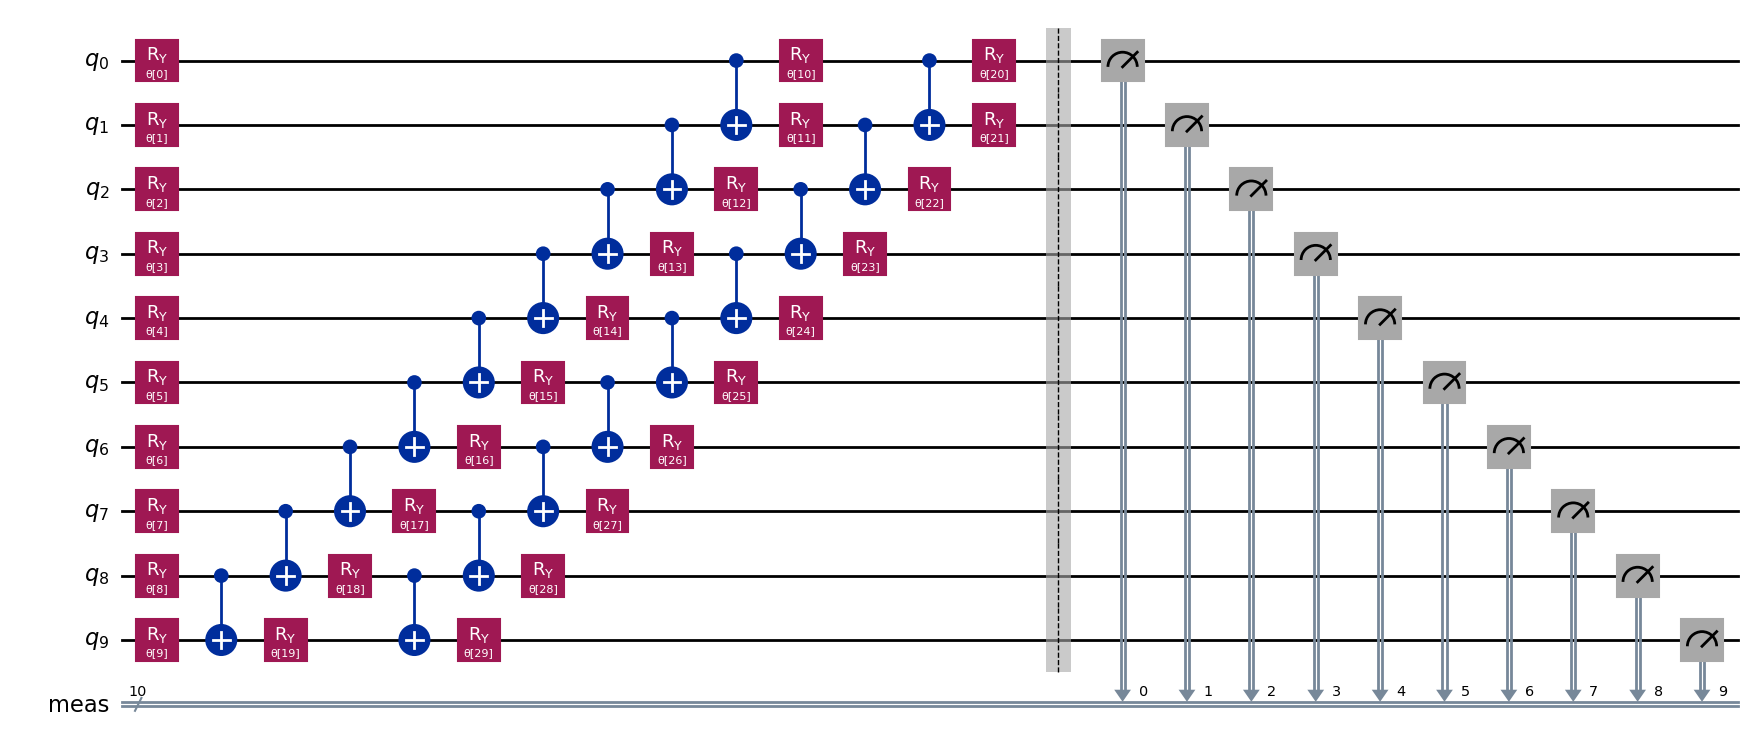

In [34]:
# Print the transpiled ansatz circuit for inspection
from IPython.display import display
# produce the figure
fig = ansatz.draw(output='mpl')
# display it in the notebook
display(fig)

[*******************   40%                       ]  4 of 10 completed


 Phase 5: Backtesting Quantum Portfolio 
Test Period: 2024-10-29 to 2024-11-12


[*********************100%***********************]  10 of 10 completed


Using 'Close' from MultiIndex test data.
Successfully downloaded 10 days of test data.

Quantum Portfolio Stocks: ['GOOG', 'AMZN', 'TSLA', 'JNJ', 'NVDA']

 Test Results
Total Return: 9.48%
Daily Volatility (Risk): 2.18%
Result: The portfolio was positive!

Plotting cumulative returns...


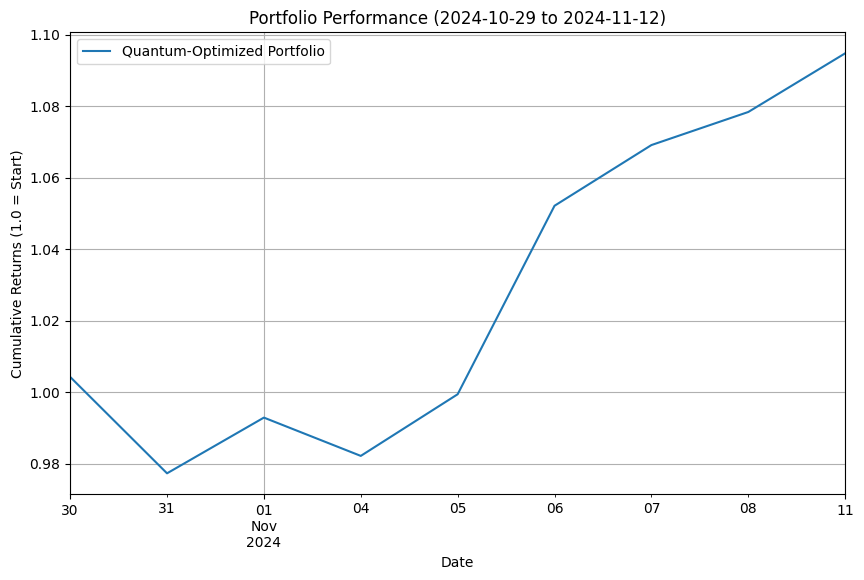

In [49]:
print("\n Phase 5: Backtesting Quantum Portfolio ")

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# Define testing time period
test_start_date = '2024-10-29'
test_end_date = '2024-11-12' # 10 trading days

print(f"Test Period: {test_start_date} to {test_end_date}")

# 2. Download Test Data for ALL 10 Original Stocks (robust, mirror training download)
print("Downloading 10-day test data for all tickers...")
# Attempt to download and extract 'Adj Close' (handle MultiIndex like training cell)
try:
    raw_test = yf.download(tickers, start=test_start_date, end=test_end_date)
    # If yfinance returns MultiIndex columns, prefer 'Adj Close' then 'Close'
    if isinstance(raw_test.columns, pd.MultiIndex):
        if 'Adj Close' in raw_test.columns.get_level_values(0):
            test_data = raw_test['Adj Close']
            print("Using 'Adj Close' from MultiIndex test data.")
        elif 'Close' in raw_test.columns.get_level_values(0):
            test_data = raw_test['Close']
            print("Using 'Close' from MultiIndex test data.")
        else:
            raise ValueError("Downloaded test data missing 'Adj Close'/'Close' levels")
    else:
        # Single-level columns: either a DataFrame of closes or a Series
        if 'Adj Close' in raw_test.columns:
            test_data = raw_test['Adj Close']
           # print("Using 'Adj Close' from test data.")
        elif 'Close' in raw_test.columns:
            test_data = raw_test['Close']
           # print("Using 'Close' from test data.")
        else:
            # raw_test might already be the proper DataFrame (e.g., when yfinance returns one-level indexed dataframe)
            test_data = raw_test
    # Clean missing values if any
    if hasattr(test_data, 'isnull') and test_data.isnull().values.any():
        test_data.ffill(inplace=True)
        test_data.dropna(inplace=True)
    print(f"Successfully downloaded {getattr(test_data, 'shape', ('', ''))[0]} days of test data.")
except Exception as e:
    print(f"Warning: test data download failed: {e}")
    import traceback
    traceback.print_exc()
    # Fallback: if training `stock_data` is available, use its last N days as test data
    if 'stock_data' in globals():
        print("Falling back to the last available days from training data for test_data.")
        try:
            test_data = stock_data.tail(10).copy()
            print(f"Using fallback test_data with {test_data.shape[0]} days from training data.")
        except Exception as e2:
            raise RuntimeError("Failed to construct fallback test_data; aborting backtest.") from e2
    else:
        raise RuntimeError("Test data unavailable and no training data fallback found.") from e

# 3. Calculate Daily Returns for the Test Period
test_returns = test_data.pct_change().dropna()

# 4. Isolate the Returns for our VQE-Selected Portfolio
# The 'selected_stocks' variable comes from Phase 4
vqe_portfolio_returns = test_returns[selected_stocks]
print(f"\nQuantum Portfolio Stocks: {selected_stocks}")

# 5. Simulate Portfolio Performance (Equal Weighting)
# We assume an equal 20% (1/5) weight for each selected stock
num_selected = len(selected_stocks)
weights = 1 / num_selected

# The portfolio's daily return is the average of the individual stock returns
vqe_portfolio_daily_return = vqe_portfolio_returns.mean(axis=1)

# 6. Calculate Cumulative Returns
# This shows how the portfolio's value grows day-by-day
vqe_cumulative_returns = (1 + vqe_portfolio_daily_return).cumprod()

# 7. Print Final Performance Metrics
total_return = (vqe_cumulative_returns.iloc[-1] - 1) * 100
volatility = vqe_portfolio_daily_return.std() * 100 # Daily volatility

print("\n Test Results")
print(f"Total Return: {total_return:.2f}%")
print(f"Daily Volatility (Risk): {volatility:.2f}%")

if total_return > 0:
    print("Result: The portfolio was positive!")
else:
    print("Result: The portfolio was not positive.")

# 8. Plot the Results
print("\nPlotting cumulative returns...")
plt.figure(figsize=(10, 6))
vqe_cumulative_returns.plot(label='Quantum-Optimized Portfolio')
plt.title(f"Portfolio Performance ({test_start_date} to {test_end_date})")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (1.0 = Start)")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# =================================================================
# --- PHASE 4: Solving with SamplingVQE + QAOAAnsatz ---
# =================================================================

print("\n Phase 4: Solving with VQE using QAOA Ansatz ")

# --- We need Sampler, Optimizer, and the VQE solver ---
from qiskit_aer.primitives import SamplerV2 as AerSampler
from qiskit_algorithms import SamplingVQE  # <-- The solver that WORKED
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals

# --- We still need to transpile ---
from qiskit import transpile
from qiskit_aer import AerSimulator

# --- THIS IS THE NEW ANSATZ (instead of RealAmplitudes) ---
from qiskit.circuit.library import QAOAAnsatz
# --------------------------------------------------------

# --- We still use MinimumEigenOptimizer to orchestrate ---
from qiskit_optimization.algorithms import MinimumEigenOptimizer


# 1. Set up the Solver Components
algorithm_globals.random_seed = 1234 

# 1a. The Sampler
sampler = AerSampler()

# 1b. The Optimizer
optimizer = SPSA(maxiter=200)

# 1c. The QAOA Repetitions (circuit depth)
reps = 3

# --- THIS IS THE FIX ---
# 1d. Create the QAOA ansatz template
# We use the 'hamiltonian' (Ising operator) from Phase 3 to build it
ansatz_template = QAOAAnsatz(hamiltonian, reps=reps)

# 1e. Transpile the ansatz
aer_backend = AerSimulator()
ansatz = transpile(ansatz_template, backend=aer_backend)
print("QAOA ansatz created and transpiled.")
# -----------------------

# 2. Instantiate the Solver
# We use SamplingVQE, which we know accepts an 'ansatz' argument
sampling_vqe_solver = SamplingVQE(
    sampler=sampler,
    ansatz=ansatz, # <-- Pass the transpiled QAOAAnsatz
    optimizer=optimizer
)

print("Solver instantiated: SamplingVQE with AerSamplerV2")

# 3. Use the Solver with MinimumEigenOptimizer
eigen_optimizer = MinimumEigenOptimizer(sampling_vqe_solver)

# 4. Solve the problem
print("\nRunning SamplingVQE (with QAOA ansatz)... This may take a moment...")
solution = eigen_optimizer.solve(qubo)
print("Solver run complete.")

# 5. Interpret and Display Results
if solution.status.name == 'SUCCESS':
    optimal_selection = solution.x
    
    print(f"\nOptimal raw vector (x): {optimal_selection}")
    
    print("\n--- QAOA-Ansatz Optimal Portfolio Selection (Top 5 Assets) ---")
    selected_stocks = []
    for i in range(len(optimal_selection)):
        if optimal_selection[i] == 1.0:
            selected_stocks.append(tickers[i])
            print(f"  - {tickers[i]}")
            
    # This list will be used by Phase 5 and 6
    print("\n'selected_stocks' list is ready for Phase 5.")
    
else:
    print("Solver did not find a feasible solution.")
    print(f"Status: {solution.status.name}")


 Phase 4: Solving with VQE using QAOA Ansatz 
QAOA ansatz created and transpiled.
Solver instantiated: SamplingVQE with AerSamplerV2

Running SamplingVQE (with QAOA ansatz)... This may take a moment...
Solver run complete.

Optimal raw vector (x): [1. 0. 1. 1. 1. 0. 0. 1. 0. 0.]

--- QAOA-Ansatz Optimal Portfolio Selection (Top 5 Assets) ---
  - AAPL
  - GOOG
  - AMZN
  - TSLA
  - V

'selected_stocks' list is ready for Phase 5.


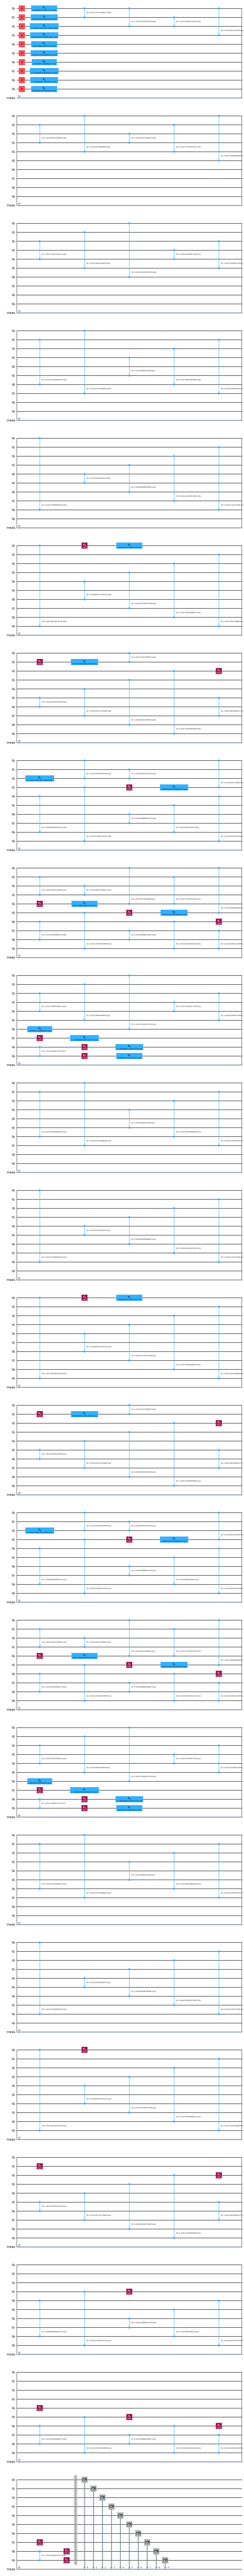

In [14]:
# Print the transpiled ansatz circuit for inspection
from IPython.display import display
# produce the figure
fig = ansatz.draw(output='mpl')
# display it in the notebook
display(fig)

[**************        30%                       ]  3 of 10 completed


 Phase 5: Backtesting QAOA Portfolio 
Test Period: 2024-10-29 to 2024-11-12


[*********************100%***********************]  10 of 10 completed


Using 'Close' from MultiIndex test data.
Successfully downloaded 10 days of test data.

QAOA Portfolio Stocks: ['AAPL', 'GOOG', 'AMZN', 'TSLA', 'V']

 Test Results (QAOA) 
Total Return: 10.83%
Daily Volatility (Risk): 2.05%
Result: The portfolio was positive!

Plotting cumulative returns...


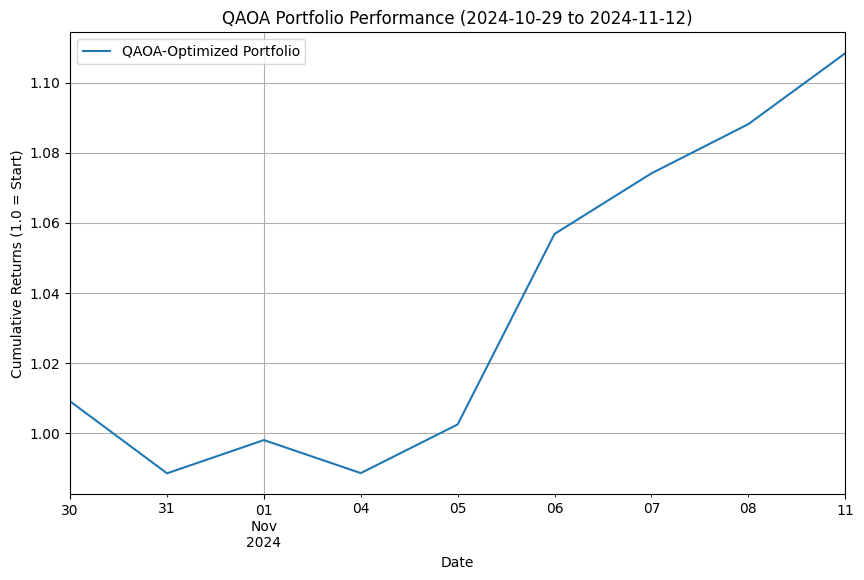

In [51]:
print("\n Phase 5: Backtesting QAOA Portfolio ")

# Import matplotlib for plotting
import matplotlib.pyplot as plt

# 1. Define Test Period Parameters (from Phase 1)
test_start_date = '2024-10-29'
test_end_date = '2024-11-12' # ~10 trading days

print(f"Test Period: {test_start_date} to {test_end_date}")

# 2. Download Test Data for ALL 10 Original Stocks
print("Downloading 10-day test data for all tickers...")
try:
    raw_test = yf.download(tickers, start=test_start_date, end=test_end_date)
    # If yfinance returns MultiIndex columns, prefer 'Adj Close' then 'Close'
    if isinstance(raw_test.columns, pd.MultiIndex):
        if 'Adj Close' in raw_test.columns.get_level_values(0):
            test_data = raw_test['Adj Close']
            print("Using 'Adj Close' from MultiIndex test data.")
        elif 'Close' in raw_test.columns.get_level_values(0):
            test_data = raw_test['Close']
            print("Using 'Close' from MultiIndex test data.")
        else:
            raise ValueError("Downloaded test data missing 'Adj Close'/'Close' levels")
    else:
        # Single-level columns (simplified logic)
        test_data = raw_test
        if 'Adj Close' in raw_test.columns:
             test_data = raw_test['Adj Close']
        
    # Clean missing values if any
    if hasattr(test_data, 'isnull') and test_data.isnull().values.any():
        test_data.ffill(inplace=True)
        test_data.dropna(inplace=True)
    print(f"Successfully downloaded {getattr(test_data, 'shape', ('', ''))[0]} days of test data.")
except Exception as e:
    print(f"An error occurred during test data download: {e}")
    # Handle fallback if necessary, though it's better to ensure download works
    if 'stock_data' in globals():
        print("Falling back to the last 10 days from training data for test_data.")
        test_data = stock_data.tail(10).copy()
    else:
        raise RuntimeError("Test data unavailable and no training data fallback found.") from e


# 3. Calculate Daily Returns for the Test Period
test_returns = test_data.pct_change().dropna()

# 4. Isolate the Returns for our QAOA-Selected Portfolio
# The 'selected_stocks' variable comes from Phase 4
qaoa_portfolio_returns = test_returns[selected_stocks]
print(f"\nQAOA Portfolio Stocks: {selected_stocks}")

# 5. Simulate Portfolio Performance (Equal Weighting)
num_selected = len(selected_stocks)
weights = 1 / num_selected

# The portfolio's daily return is the average of the individual stock returns
qaoa_portfolio_daily_return = qaoa_portfolio_returns.mean(axis=1)

# 6. Calculate Cumulative Returns
qaoa_cumulative_returns = (1 + qaoa_portfolio_daily_return).cumprod()

# 7. Print Final Performance Metrics
total_return = (qaoa_cumulative_returns.iloc[-1] - 1) * 100
volatility = qaoa_portfolio_daily_return.std() * 100 # Daily volatility

print("\n Test Results (QAOA) ")
print(f"Total Return: {total_return:.2f}%")
print(f"Daily Volatility (Risk): {volatility:.2f}%")

if total_return > 0:
    print("Result: The portfolio was positive!")
else:
    print("Result: The portfolio was not positive.")

# 8. Plot the Results
print("\nPlotting cumulative returns...")
plt.figure(figsize=(10, 6))
qaoa_cumulative_returns.plot(label='QAOA-Optimized Portfolio')
plt.title(f"QAOA Portfolio Performance ({test_start_date} to {test_end_date})")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (1.0 = Start)")
plt.legend()
plt.grid(True)
plt.show()

In [63]:
print("\n Phase 6: Benchmarking & Analysis ")
from qiskit_optimization.minimum_eigensolvers import NumPyMinimumEigensolver


# Benchmark 1: Classical (Exact) Solver 
# This finds the 100% mathematically optimal solution.
print("Running classical solver for 'perfect' benchmark...")
classical_solver = NumPyMinimumEigensolver()
classical_optimizer = MinimumEigenOptimizer(classical_solver)
classical_solution = classical_optimizer.solve(qubo)

# Get the stocks selected by the classical solver
classical_selection = classical_solution.x
classical_stocks = []
for i in range(len(classical_selection)):
    if classical_selection[i] == 1.0:
        classical_stocks.append(tickers[i])

print(f"Classical Portfolio Stocks: {classical_stocks}")

# Backtest the classical portfolio
classical_portfolio_returns = test_returns[classical_stocks]
classical_daily_return = classical_portfolio_returns.mean(axis=1)
classical_cumulative_returns = (1 + classical_daily_return).cumprod()


# --- 2. Benchmark 2: Naive (Top 5 Returns) Strategy ---
# This strategy simply picks the 5 stocks that had the highest
# average return during the 20-day "training" period.
print("Running 'naive' benchmark (top 5 training returns)...")
top_5_indices = np.argsort(mu)[-5:] 
naive_stocks = [tickers[i] for i in top_5_indices]

print(f"Naive Portfolio Stocks: {naive_stocks}")



 Phase 6: Benchmarking & Analysis 
Running classical solver for 'perfect' benchmark...
Classical Portfolio Stocks: ['AAPL', 'AMZN', 'TSLA', 'JPM', 'JNJ']
Running 'naive' benchmark (top 5 training returns)...
Naive Portfolio Stocks: ['NVDA', 'AAPL', 'PG', 'TSLA', 'JNJ']



--- Comparison of Optimization Methods ---
                  Method  Total Return (%)  Daily Volatility (%)
0         Quantum (QAOA)         10.832140              2.049652
1      Classical (Exact)          8.273063              2.237296
2  Naive (Top 5 Returns)          5.457261              1.613991


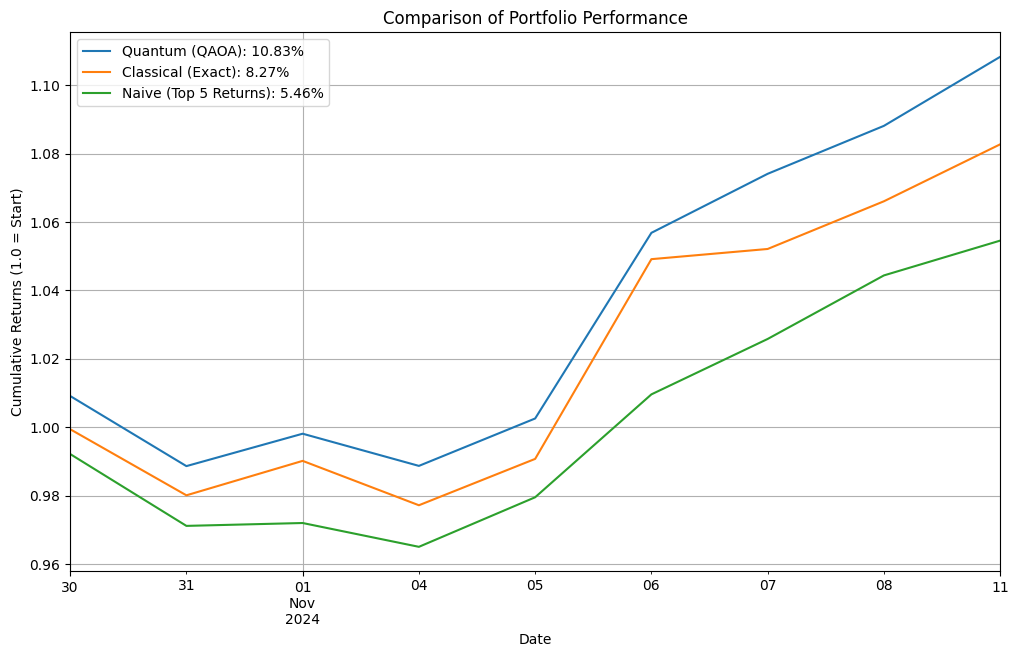

In [ ]:
# Final Comparison of Results 
import pandas as pd
import matplotlib.pyplot as plt

# Aggregate the results into a DataFrame for comparison
comparison_data = {
    "Method": ["Quantum (QAOA)", "Classical (Exact)", "Naive (Top 5 Returns)"],
    "Total Return (%)": [qaoa_total_return, classical_total_return, naive_total_return],
    "Daily Volatility (%)": [
        qaoa_portfolio_daily_return.std() * 100,
        classical_daily_return.std() * 100,
        naive_daily_return.std() * 100
    ]
}
comparison_df = pd.DataFrame(comparison_data)

# Display the comparison table
print("\n--- Comparison of Optimization Methods ---")
print(comparison_df)

# Plot cumulative returns for all three methods
plt.figure(figsize=(12, 7))
qaoa_cumulative_returns.plot(label=f"Quantum (QAOA): {qaoa_total_return:.2f}%")
classical_cumulative_returns.plot(label=f"Classical (Exact): {classical_total_return:.2f}%")
naive_cumulative_returns.plot(label=f"Naive (Top 5 Returns): {naive_total_return:.2f}%")

plt.title("Comparison of Portfolio Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns (1.0 = Start)")
plt.legend()
plt.grid(True)
plt.show()

 Final Comparison Plot


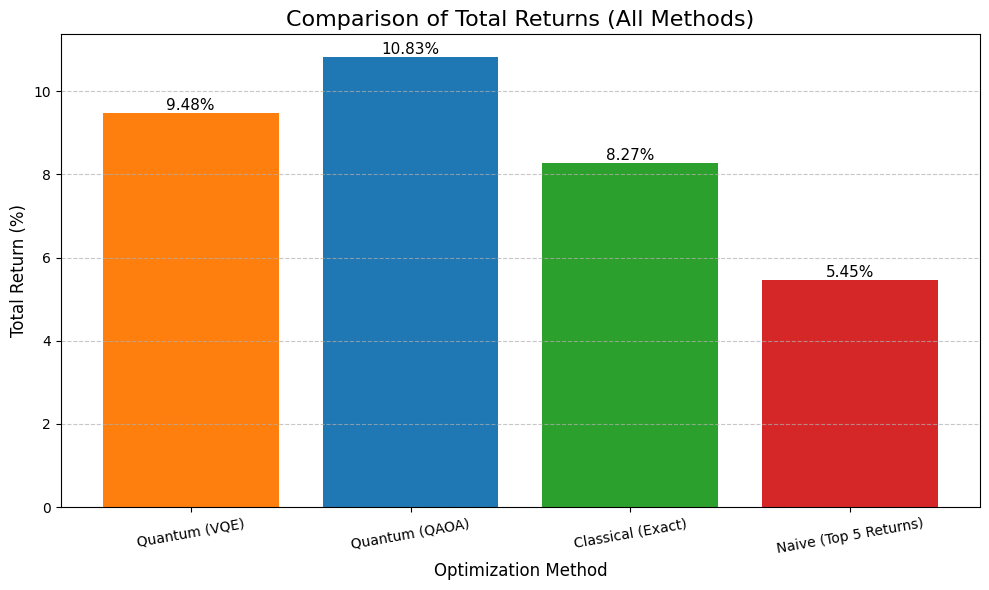

Comparison chart saved as 'all_methods_comparison_bar_chart.png'


In [67]:
# --- Bar Graph Comparison with Percentages (All 4 Methods) ---
import matplotlib.pyplot as plt
import pandas as pd

print(" Final Comparison Plot")

# --- We will hardcode the final results from your notebook output ---
# VQE (from Cell #13): 9.48%
# QAOA (from Cell #16): 10.83%
# Classical (from Cell #17): 8.27%
# Naive (from Cell #17): 5.45%

methods = [
    "Quantum (VQE)", 
    "Quantum (QAOA)", 
    "Classical (Exact)", 
    "Naive (Top 5 Returns)"
]

total_returns = [
    9.48,  # Hardcoded VQE result
    10.83,  # Hardcoded QAOA result
    8.27,  # Hardcoded Classical result
    5.45   # Hardcoded Naive result
]

# --- Create bar graph for Total Returns ---
plt.figure(figsize=(10, 6))
# Assign colors to make VQE and QAOA distinct
colors = ['#ff7f0e', '#1f77b4', '#2ca02c', '#d62728'] # Orange, Blue, Green, Red
bars = plt.bar(methods, total_returns, color=colors)

plt.title("Comparison of Total Returns (All Methods)", fontsize=16)
plt.ylabel("Total Return (%)", fontsize=12)
plt.xlabel("Optimization Method", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=10) # Added slight rotation for readability

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.2f}%", 
             ha='center', va='bottom', fontsize=11) # va='bottom' puts it just above the bar

plt.tight_layout()
plt.savefig("all_methods_comparison_bar_chart.png")
plt.show()

print("Comparison chart saved as 'all_methods_comparison_bar_chart.png'")